In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from tqdm import tqdm
from dataclasses import dataclass
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from typing import List, Dict
from CommonFunctions import *
%matplotlib inline

In [3]:
@dataclass
class LearningParameters:
    batch_size: int = 64
    cpu_count: int = os.cpu_count()
    learning_rate: float = 0.05
    momentum: float = 0.9
    weight_decay: float = 0.0001
    epochs: int = 150
    device: torch.device = torch.device(
        'cuda' if torch.cuda.is_available() else 'cpu')
    dropout: float = 0.3
    batch_norm: bool = False
PARAMS = LearningParameters()

In [4]:
data_path = Path('./data/')

def load_dataset(path, transform, subset=None, download=False):
    train_data = datasets.CIFAR10(root=path, 
                                  train=True, 
                                  download=download, 
                                  transform=transform)
    test_data = datasets.CIFAR10(root=path, 
                                 train=False,
                                 download=download, 
                                 transform=transform)
    if subset is not None:
        train_data = Subset(train_data, range(subset[0]))
        test_data = Subset(test_data, range(subset[1]))
    train_dataloader = DataLoader(dataset=train_data, 
                                  batch_size=PARAMS.batch_size,
                                  shuffle=True,
                                  pin_memory=True)
    test_dataloader = DataLoader(dataset=test_data,
                                 batch_size=PARAMS.batch_size,
                                 shuffle=False,
                                 pin_memory=True)
    return train_data, test_data, train_dataloader, test_dataloader
train_data, test_data, _, _ = load_dataset(data_path, transforms.ToTensor(), download=True)
len(train_data), len(test_data)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [5]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
train_data[0][0].shape

torch.Size([3, 32, 32])

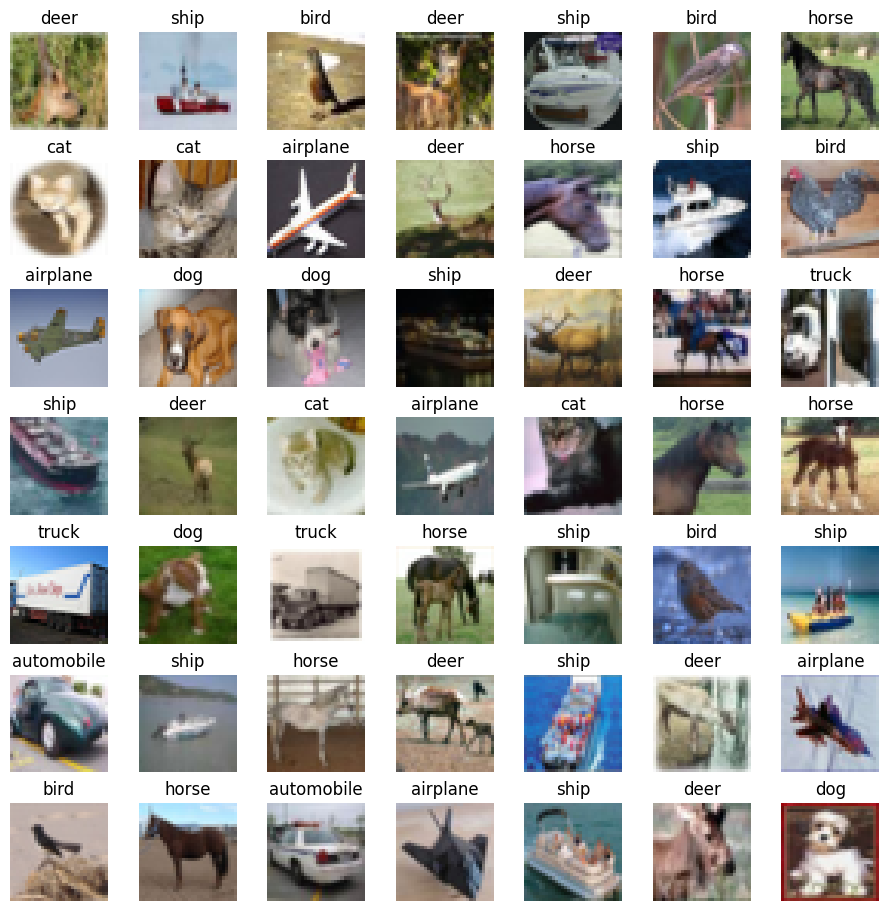

In [7]:
def plot_random_images(dataset, shape, dataset_labels):
    figure, axes = plt.subplots(*shape, layout='constrained', figsize=(9, 9))
    for index, ax in enumerate(figure.axes):
        random_idx = torch.randint(0, len(dataset), size=[1]).item()
        img, lab = dataset[random_idx]
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.set(title=dataset_labels[lab])
        ax.axis(False)
plot_random_images(train_data, (7, 7), classes)

# Defining modular VGG models

In [8]:
class ModularVGG(nn.Module):
    """
    VGG model that can be arbitrary extended
    """
    def __init__(self, input_layer_size: int, num_of_classes: int, image_size: int, config: Dict):
        super(ModularVGG, self).__init__()
        self.latest_layer_size = input_layer_size
        self.image_size = image_size
        
        self.conv_layer = nn.Sequential(
            *self._conv_layers(**config['CONV']),
            nn.Flatten()
        )
        
        self.classifier = nn.Sequential(
            *self._linear_layers(**config['FC']),
            nn.Linear(in_features=self.latest_layer_size,
                      out_features=num_of_classes),
            nn.Softmax(dim=1)
        )
        
        self.initialize_weights()
        
    def _conv_layers(self, conv_layers: List[List[int]],
                           kernel_params: Dict,
                           batch_norm: bool = False,
                           activation: nn.Module = nn.ReLU(inplace=True)) -> List[nn.Module]:
        layers = []
        for conv_layer in conv_layers:
            for out_channels in conv_layer:
                layers += [nn.Conv2d(in_channels=self.latest_layer_size,
                                     out_channels=out_channels, **kernel_params), activation]
                self.latest_layer_size = out_channels
            layers += [nn.MaxPool2d(kernel_size=2)]
            layers += [nn.BatchNorm2d(num_features=self.latest_layer_size)] if batch_norm else []
        self.latest_layer_size = (self.image_size // 2**len(conv_layers))**2 * self.latest_layer_size
        return layers
                
    
    def _linear_layers(self, layer_sizes: List[int],
                             dropout: float = 0.,
                             activation: nn.Module = nn.ReLU(inplace=True)) -> List[nn.Module]:
        layers = []
        for layer_size in layer_sizes:
            layers += [nn.Dropout(p=dropout)] if dropout > 0 else []
            layers += [nn.Linear(in_features=self.latest_layer_size,
                                 out_features=layer_size), activation]
            self.latest_layer_size = layer_size
        return layers
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_layer(x))

In [9]:
KERNEL_PARAMS = dict(kernel_size=3, stride=1, padding=1)
vgg_cfg = dict(
    vgg11=dict(
        CONV=dict(
            conv_layers=[[64],
                         [128],
                         [256, 256],
                         [512, 512],
                         [512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    )
)
model = ModularVGG(input_layer_size=3,
                   num_of_classes=10,
                   image_size=32,
                   config=vgg_cfg['vgg11'])
model

ModularVGG(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

# Comparing VGG11 with and without data normalization

First let's check how normalization affects the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


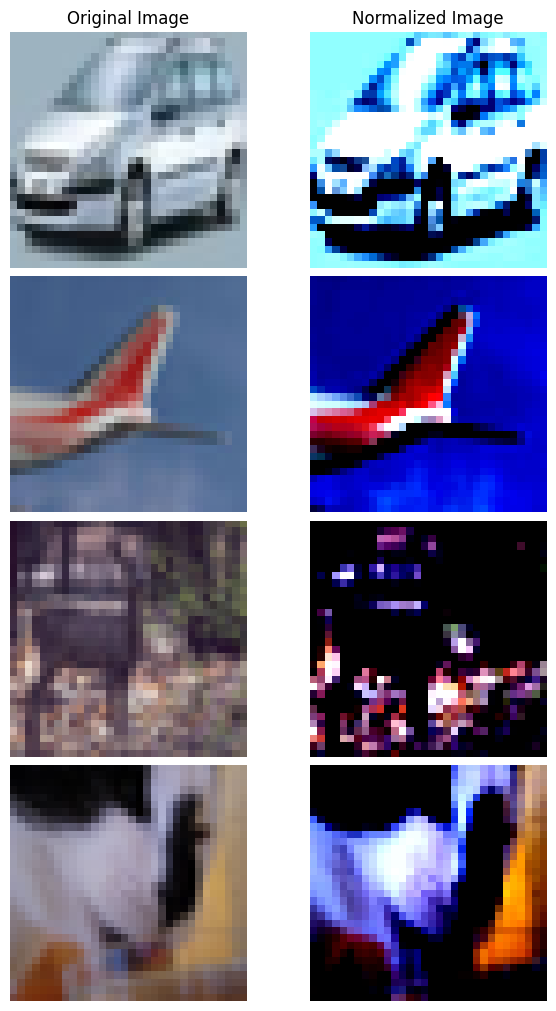

In [10]:
def compare_normalization(dataset, num_of_images):
    figure, axes = plt.subplots(num_of_images, 2, layout='constrained', figsize=(6, 6 + num_of_images))
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
    for index in range(num_of_images):
        random_idx = torch.randint(0, len(dataset), size=[1]).item()
        img, _ = dataset[random_idx]
        axes[index, 0].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[index, 1].imshow(np.transpose(transform(img).numpy(), (1, 2, 0)))
        for idx in range(2):
            axes[index, idx].axis(False)
    axes[0, 0].set(title='Original Image')
    axes[0, 1].set(title='Normalized Image')
compare_normalization(train_data, 4)

Training both models

In [11]:
transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
def accuracy(y_pred, y_true):
    return (y_true == y_pred).sum().item() / len(y_pred)

def train_step(model, dataloader, criterion, accuracy_function, optimizer, device):
    train_loss, accuracy = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        accuracy += accuracy_function(y_pred.argmax(dim=1), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= (data_len := len(dataloader))
    accuracy /= data_len
    return train_loss, accuracy

def test_step(model, dataloader, criterion, accuracy_function, device):
    test_loss, accuracy = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = criterion(test_pred, y)
            test_loss += loss.item()
            accuracy += accuracy_function(test_pred.argmax(dim=1), y)
        test_loss /= (data_len := len(dataloader))
        accuracy /= data_len
    return test_loss, accuracy

def plot_loss_and_accuracy(title, epochs, loss_dict, accuracy_dict, file):
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 6))
        x_axis = range(1, epochs + 1)
        for loss_type, loss in loss_dict.items():
            axes[0].plot(x_axis, loss, label=f'{loss_type}: {min(loss):.3f}')
        axes[0].set(ylabel='Loss', title=title)
        axes[0].legend()
        enhance_plot(figure, axes[0], glow=True)
        for accuracy_type, accuracy in accuracy_dict.items():
            axes[1].plot(x_axis, accuracy, label=f'{accuracy_type}: {max(accuracy):.3f}')
        axes[1].set(ylabel='Accuracy')
        axes[1].legend()
        enhance_plot(figure, axes[1], glow=True)
        figure.savefig(f'images/{file}.png')
        return figure, axes

In [13]:
_, _, train_dataloader, test_dataloader = load_dataset(
    data_path, transforms.ToTensor(), (20000, 5000))
model = ModularVGG(input_layer_size=3,
                   num_of_classes=10,
                   image_size=32,
                   config=vgg_cfg['vgg11']).to(PARAMS.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=PARAMS.learning_rate)

loss_dict = {}
acc_dict = {}
train_time_start = timer()
train_loss = []
test_acc = []
for epoch in tqdm(range(PARAMS.epochs)):
    train_metrics = train_step(
        model, train_dataloader, loss_fn, accuracy, optimizer, PARAMS.device
    )
    test_metrics = test_step(
        model, test_dataloader, loss_fn, accuracy, PARAMS.device
    )
    train_loss.append(train_metrics[0])
    test_acc.append(test_metrics[1])
loss_dict['Train with no normalization'] = train_loss
acc_dict['Test with no normalization'] = test_acc
train_time = timer() - train_time_start
print(f'Time: {train_time:.3f} seconds')

100%|██████████| 150/150 [16:15<00:00,  6.50s/it]

Time: 975.460 seconds


In [14]:
_, _, train_dataloader, test_dataloader = load_dataset(
    data_path, transform_normalized, (20000, 5000))

model = ModularVGG(input_layer_size=3,
                   num_of_classes=10,
                   image_size=32,
                   config=vgg_cfg['vgg11']).to(PARAMS.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=PARAMS.learning_rate)

train_time_start = timer()
train_loss = []
test_acc = []
for epoch in tqdm(range(PARAMS.epochs)):
    train_metrics = train_step(
        model, train_dataloader, loss_fn, accuracy, optimizer, PARAMS.device
    )
    test_metrics = test_step(
        model, test_dataloader, loss_fn, accuracy, PARAMS.device
    )
    train_loss.append(train_metrics[0])
    test_acc.append(test_metrics[1])
loss_dict['Train with normalization'] = train_loss
acc_dict['Test with normalization'] = test_acc
train_time = timer() - train_time_start
print(f'Time: {train_time:.3f} seconds')

100%|██████████| 150/150 [22:15<00:00,  8.90s/it]

Time: 1335.073 seconds


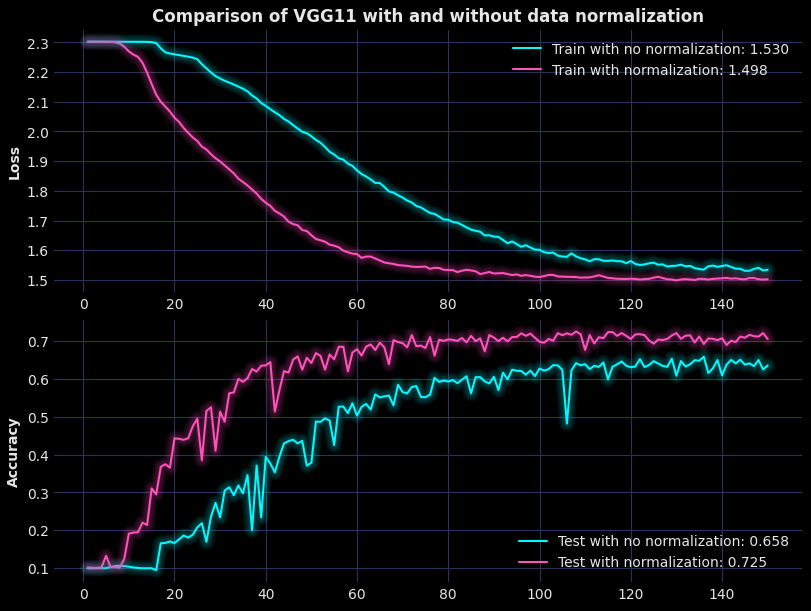

In [15]:
title = 'Comparison of VGG11 with and without data normalization'
plot_loss_and_accuracy(title, PARAMS.epochs, loss_dict, acc_dict, 'Normalization');

Normalizing images leads to faster training and higher saturation accuracy

# Comparing models with and without weight decay

In [20]:
config = {'without both': (0, 0),
          'with weight decay': (PARAMS.weight_decay, 0),
          'with momentum': (0, PARAMS.momentum),
          'with both': (PARAMS.weight_decay, PARAMS.momentum)}
loss_dict = {}
acc_dict = {}
_, _, train_dataloader, test_dataloader = load_dataset(
        data_path, transform_normalized, (10000, 2500))

for key, (weight_decay, momentum) in config.items():
    model = ModularVGG(input_layer_size=3,
                       num_of_classes=10,
                       image_size=32,
                       config=vgg_cfg['vgg11']).to(PARAMS.device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=PARAMS.learning_rate,
                                momentum=momentum,
                                weight_decay=weight_decay)
    
    train_time_start = timer()
    train_loss = []
    test_acc = []
    for epoch in tqdm(range(PARAMS.epochs)):
        train_metrics = train_step(
            model, train_dataloader, loss_fn, accuracy, optimizer, PARAMS.device)
        test_metrics = test_step(
            model, test_dataloader, loss_fn, accuracy, PARAMS.device)
        train_loss.append(train_metrics[0])
        test_acc.append(test_metrics[1])
    loss_dict[key] = train_loss
    acc_dict[key] = test_acc
    train_time = timer() - train_time_start
    print(f'Time: {train_time:.3f} seconds')

100%|██████████| 150/150 [09:51<00:00,  3.95s/it]


Time: 591.840 seconds


100%|██████████| 150/150 [10:32<00:00,  4.22s/it]


Time: 632.948 seconds


100%|██████████| 150/150 [11:32<00:00,  4.62s/it]


Time: 692.837 seconds


100%|██████████| 150/150 [10:41<00:00,  4.28s/it]

Time: 641.485 seconds


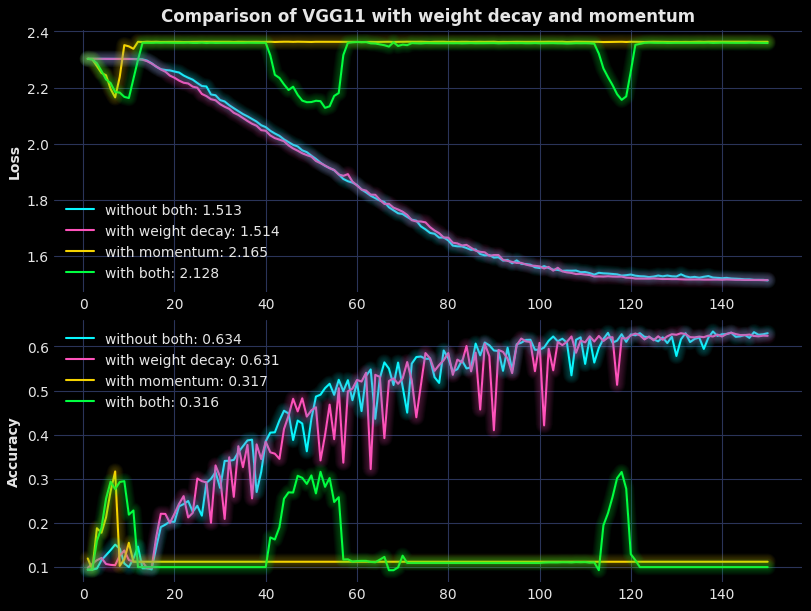

In [21]:
title = 'Comparison of VGG11 with weight decay and momentum'
plot_loss_and_accuracy(title, PARAMS.epochs, loss_dict, acc_dict, 'Regularization');